## AR Mock

### Questions
- What is the complexity of the model? -> Quantify variables and runtime exactly!
- What about the identifiability constraints?

In [49]:
%reset -f
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

In [50]:
ts = pd.read_csv('./data/ts14-15.csv')
ts = ts.drop('Unnamed: 0', 1)

# Build team index
teams = ts.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

ts = pd.merge(ts, teams, left_on='home_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_home'}).drop('team', 1)
ts = pd.merge(ts, teams, left_on='away_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_away'}).drop('team', 1)

ts = ts.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = ts.home_score.values
observed_away_goals = ts.away_score.values

home_team = ts.i_home.values
away_team = ts.i_away.values

num_teams = len(ts.i_home.drop_duplicates())
num_games = len(home_team)

ts['t'] = 1
ts['t'] = ts['t'].groupby(ts['home_team']).cumsum()

grouped = ts.groupby('t')

observed_home_goals = np.zeros((19,20))
observed_away_goals = np.zeros((19,20))
home_team = np.zeros((19,20))
away_team = np.zeros((19,20))

for t, group in grouped:
    observed_home_goals[t-1] = group.home_score.values
    observed_away_goals[t-1] = group.away_score.values
    home_team[t-1] = group.i_home.values
    away_team[t-1] = group.i_away.values
    
observed_home_goals = observed_home_goals.astype(np.int64)
observed_away_goals = observed_away_goals.astype(np.int64)
home_team = home_team.astype(np.int64)
away_team = away_team.astype(np.int64)

[T, num_teams] = observed_home_goals.shape

In [8]:
columns = ['home_score', 'away_score', 'home_team', 'away_team', 'i_home', 'i_away']

data = [[1,0,'Arsenal','Liverpool',0,1],
        [1,1,'Liverpool','Burnley',1,2],
        [2,4,'Burnley','Arsenal',2,0],
        [0,3,'Liverpool','Arsenal',1,0],
        [1,1,'Burnley','Liverpool',2,1],
        [5,0,'Arsenal','Burnley',0,2],
        [3,0,'Arsenal','Liverpool',0,1],
        [1,1,'Liverpool','Burnley',1,2],
        [0,3,'Burnley','Arsenal',2,0],
        [0,3,'Liverpool','Arsenal',1,0],
        [1,1,'Burnley','Liverpool',2,1],
        [5,0,'Arsenal','Burnley',0,2]]

ts = pd.DataFrame(data=data, columns=columns)

ts['t'] = 1
ts['t'] = ts['t'].groupby(ts['home_team']).cumsum()
grouped = ts.groupby('t')

observed_home_goals = np.zeros((4,3))
observed_away_goals = np.zeros((4,3))
home_team = np.zeros((4,3))
away_team = np.zeros((4,3))

for t, group in grouped:
    observed_home_goals[t-1] = group.home_score.values
    observed_away_goals[t-1] = group.away_score.values
    home_team[t-1] = group.i_home.values
    away_team[t-1] = group.i_away.values
    
observed_home_goals = observed_home_goals.astype(np.int64)
observed_away_goals = observed_away_goals.astype(np.int64)
home_team = home_team.astype(np.int64)
away_team = away_team.astype(np.int64)

[T, num_teams] = observed_home_goals.shape

print(ts)

print(observed_home_goals)
print(home_team)

observed_home_goals[:,home_team]

    home_score  away_score  home_team  away_team  i_home  i_away  t
0            1           0    Arsenal  Liverpool       0       1  1
1            1           1  Liverpool    Burnley       1       2  1
2            2           4    Burnley    Arsenal       2       0  1
3            0           3  Liverpool    Arsenal       1       0  2
4            1           1    Burnley  Liverpool       2       1  2
5            5           0    Arsenal    Burnley       0       2  2
6            3           0    Arsenal  Liverpool       0       1  3
7            1           1  Liverpool    Burnley       1       2  3
8            0           3    Burnley    Arsenal       2       0  3
9            0           3  Liverpool    Arsenal       1       0  4
10           1           1    Burnley  Liverpool       2       1  4
11           5           0    Arsenal    Burnley       0       2  4
[[1 1 2]
 [0 1 5]
 [3 1 0]
 [0 1 5]]
[[0 1 2]
 [1 2 0]
 [0 1 2]
 [1 2 0]]


array([[[1, 1, 2],
        [1, 2, 1],
        [1, 1, 2],
        [1, 2, 1]],

       [[0, 1, 5],
        [1, 5, 0],
        [0, 1, 5],
        [1, 5, 0]],

       [[3, 1, 0],
        [1, 0, 3],
        [3, 1, 0],
        [1, 0, 3]],

       [[0, 1, 5],
        [1, 5, 0],
        [0, 1, 5],
        [1, 5, 0]]])

In [ ]:
with pm.Model() as model:
    # global home and intercept params?
    home = pm.Normal('home', 0, .0001)
    intercept = pm.Normal('intercept', 0, .0001)
    tau_att =  pm.Exponential('tau_att', 1./.02)
    tau_def =  pm.Exponential('tau_def', 1./.02)

    atts = pm.GaussianRandomWalk('atts', tau_att**-2, shape=[num_teams, T])
    defs = pm.GaussianRandomWalk('defs', tau_def**-2, shape=[num_teams, T])
    
    home_theta  = tt.exp(intercept + home + atts[home_team,:] + defs[away_team,:])
    away_theta  = tt.exp(intercept + atts[away_team,:] + defs[home_team,:])
    
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals.T)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals.T)

In [ ]:
# OLD
with pm.Model() as model:
    # global home and intercept params?
    home = pm.Normal('home', 0, .0001)
    intercept = pm.Normal('intercept', 0, .0001)
    tau_att =  pm.Exponential('tau_att', 1./.02)
    tau_def =  pm.Exponential('tau_def', 1./.02)

    atts = pm.GaussianRandomWalk('atts', tau_att**-2, shape=[T, num_teams])
    defs = pm.GaussianRandomWalk('defs', tau_def**-2, shape=[T, num_teams])
    
    home_theta  = tt.exp(intercept + home + atts[:, home_team] + defs[:, away_team])
    away_theta  = tt.exp(intercept + atts[:, away_team] + defs[:, home_team])

    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

In [ ]:
# Fit data, starting with the MAP
# Try variational inference
with model:
    mu, sds, elbo = pm.variational.advi(n=200000)
    
with model:
    start = mu
    step = pm.Metropolis()
    trace = pm.sample(20000, step)

In [ ]:
mu['atts']

In [ ]:
atts2 = trace[atts][19000]
atts2[:,home_team]
observed_home_goals
# y = np.arange(35).reshape(5,7)
# y
# y[np.array([0,2,4]), np.array([0,1,2])]

In [ ]:
att_hats = trace['atts']
att_hats = np.swapaxes(att_hats,0,1)
att_hats = np.swapaxes(att_hats,1,2)

# Team 0
att_means = []
att_means = [n.mean() for n in att_hats]

att_means

## Manual approach

In [ ]:
with pm.Model() as model:
    # global home and intercept params?
    home = pm.Normal('home', 0, .0001)
    intercept = pm.Normal('intercept', 0, .0001)
    tau_att =  pm.Exponential('tau_att', 1./.02)
    tau_def =  pm.Exponential('tau_def', 1./.02)

    atts = pm.GaussianRandomWalk('atts', tau_att**-2, shape=[T, num_teams])
    defs = pm.GaussianRandomWalk('defs', tau_def**-2, shape=[T, num_teams])
    
    home_theta  = tt.exp(intercept + home + atts[:, home_team] + defs[:, away_team])
    away_theta  = tt.exp(intercept + atts[:, away_team] + defs[:, home_team])

    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

In [ ]:
print(ts)
print(observed_home_goals)
print(home_team)

In [ ]:
T

In [ ]:
atts = []
defs = []

with pm.Model() as model:
    home = pm.Normal('home', 0, .0001)
    intercept = pm.Normal('intercept', 0, .0001)
    tau_att =  pm.Exponential('tau_att', 1./.02)
    tau_def =  pm.Exponential('tau_def', 1./.02)
    
    for team in range(num_teams):
        atts.append(pm.GaussianRandomWalk('atts_' + str(team), tau_att**-2, shape=[T]))
        defs.append(pm.GaussianRandomWalk('defs_' + str(team), tau_att**-2, shape=[T]))
    
    for t in range(T):
        home_thetas = tt.exp(intercept + home + atts[home,:] + defs[at,:])
        away_thetas = tt.exp(intercept + atts[at] + defs[ht])
    
    home_points = pm.Poisson('home_points', mu=home_thetas, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_thetas, observed=observed_away_goals)

In [ ]:
# Try variational inference
with model:
    mu, sds, elbo = pm.variational.advi(n=200000)

In [ ]:
# MCMC
with model:
    niter = 15000
    start = mu
    step = pm.Metropolis()
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)

In [ ]:
pm.traceplot(trace, [home, intercept, tau_att, tau_def])

In [ ]:
att_hats = trace['atts']
att_hats = np.swapaxes(att_hats,0,1)
att_hats = np.swapaxes(att_hats,1,2)
print(att_hats.shape)

for i,att in enumerate(att_hats):
    att_means[i] = [n.mean() for n in att]

# from scipy import stats
# att_modes = [stats.mode(n) for n in att_hats[0]]

In [ ]:
for am in att_means:
    plt.plot(am)

In [ ]:
with model:
    # Start next run at the last sampled position.
    step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
    trace = pm.sample(2000, step, start=mu)
    
# with model:
#     start = pm.find_MAP()
#     step = pm.NUTS(state=start)
#     trace = pm.sample(2000, step, start=start)

In [ ]:
figsize(12,6)
pm.traceplot(trace, ['atts', 'defs'])

In [56]:
# print(ts)
num_games

380

In [57]:
with pm.Model() as model:    
    # global model parameters
    home        = pm.Normal('home',      0, .0001)
    tau_att     = pm.Gamma('tau_att',   .1, .1)
    tau_def     = pm.Gamma('tau_def',   .1, .1)
    intercept   = pm.Normal('intercept', 0, .0001)

    # Make auto-regressive
    # [1] Define t0
    atts = [pm.Normal("atts0", mu = 0, tau = tau_att, shape = num_teams)]
    defs = [pm.Normal("defs0", mu = 0, tau = tau_def, shape = num_teams)]
    
    home_thetas = [tt.exp(intercept + home + atts[0][home_team[0,:]] + defs[0][away_team[0,:]])]
    away_thetas = [tt.exp(intercept + atts[0][away_team[0,:]] + defs[0][home_team[0,:]])]
    
    home_points = [pm.Poisson('home_points0', mu=home_thetas[0], observed=observed_home_goals[0,:])]
    away_points = [pm.Poisson('away_points0', mu=away_thetas[0], observed=observed_away_goals[0,:])]
    
    # [2] Define t1-T: "stack plates"
    for t in range(1,T):
        atts.append(pm.Normal("atts{0}".format(t), mu = atts[t-1], tau = tau_att, shape = num_teams))
        defs.append(pm.Normal("defs{0}".format(t), mu = defs[t-1], tau = tau_def, shape = num_teams))
    
        home_thetas.append(tt.exp(intercept + home + atts[t][home_team[t,:]] + defs[t][away_team[t,:]]))
        away_thetas.append(tt.exp(intercept + atts[t][away_team[t,:]] + defs[t][home_team[t,:]]))

        # likelihood of observed data
        home_points.append(pm.Poisson('home_points', mu=home_thetas[t], observed=observed_home_goals[t,:]))
        away_points.append(pm.Poisson('away_points', mu=away_thetas[t], observed=observed_away_goals[t,:]))

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


In [59]:
# Fit data, starting with the MAP
# Try variational inference
with model:
    mu, sds, elbo = pm.variational.advi(n=200000)
    
with model:
    start = mu
    step = pm.Metropolis()
    trace = pm.sample(20000, step)

Iteration 0 [0%]: ELBO = -4540.22
Iteration 20000 [10%]: ELBO = -1394.91
Iteration 40000 [20%]: ELBO = -1377.85
Iteration 60000 [30%]: ELBO = -1358.17
Iteration 80000 [40%]: ELBO = -1330.45
Iteration 100000 [50%]: ELBO = -1326.51
Iteration 120000 [60%]: ELBO = -1347.88
Iteration 140000 [70%]: ELBO = -1384.91
Iteration 160000 [80%]: ELBO = -1415.45
Iteration 180000 [90%]: ELBO = -1335.99
Finished [100%]: ELBO = -1349.51
 [-----------------100%-----------------] 20000 of 20000 complete in 252.7 sec

In [ ]:
with model:
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start)

In [60]:
trace.varnames

['home',
 'tau_att_log',
 'tau_def_log',
 'intercept',
 'atts0',
 'defs0',
 'atts1',
 'defs1',
 'atts2',
 'defs2',
 'atts3',
 'defs3',
 'atts4',
 'defs4',
 'atts5',
 'defs5',
 'atts6',
 'defs6',
 'atts7',
 'defs7',
 'atts8',
 'defs8',
 'atts9',
 'defs9',
 'atts10',
 'defs10',
 'atts11',
 'defs11',
 'atts12',
 'defs12',
 'atts13',
 'defs13',
 'atts14',
 'defs14',
 'atts15',
 'defs15',
 'atts16',
 'defs16',
 'atts17',
 'defs17',
 'atts18',
 'defs18',
 'tau_att',
 'tau_def']

array([[<matplotlib.axes.AxesSubplot object at 0x1d768ac90>,
        <matplotlib.axes.AxesSubplot object at 0x1e23ac090>]], dtype=object)

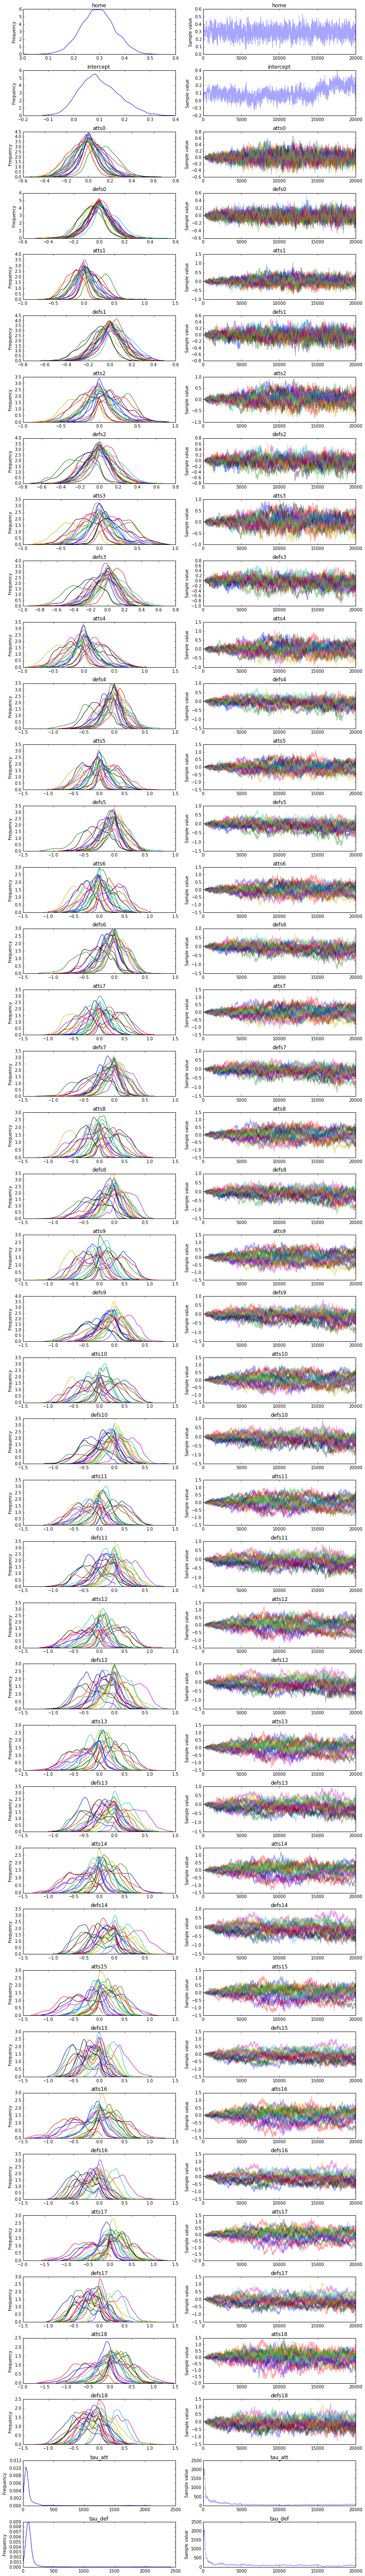

In [61]:
pm.traceplot(trace)

In [75]:
atts.shape

(20, 19)

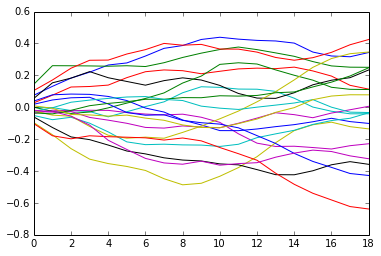

In [74]:
atts = []

for t in range(T):
    tmp = trace['atts{0}'.format(t)]
    tmp = np.swapaxes(tmp,0,1)
    atts.append([n.mean() for n in tmp])
    
# plt.plot(range(T),atts[0])
range(T)
atts = np.swapaxes(atts,0,1)

x = range(T)

for i in range(num_teams):
    plt.plot(x, atts[i])
    
plt.legend()
plt.show()

In [125]:
x = range(T)

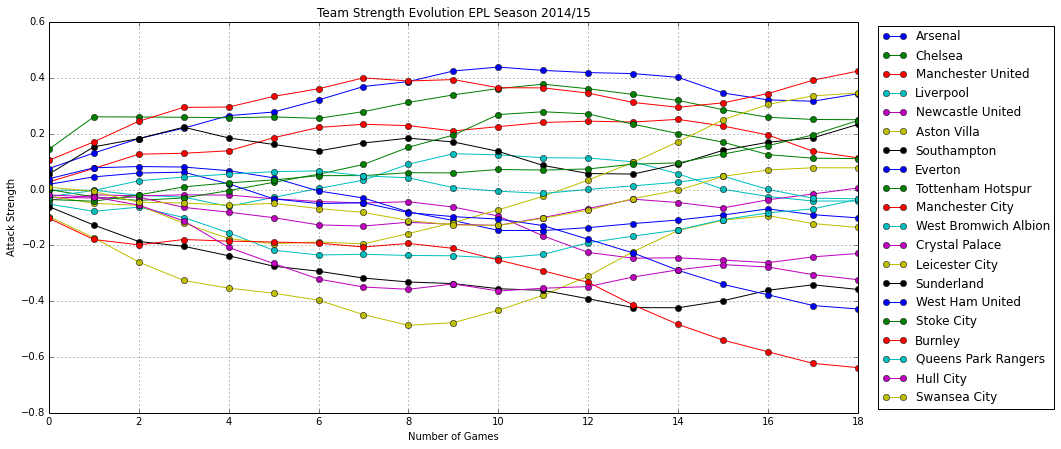

In [134]:
fig, ax = plt.subplots()
fig.set_size_inches(14.5, 7)

for i in range(num_teams):
    plt.plot(x, atts[i], marker='o', label=teams['team'][i])

plt.title('Team Strength Evolution EPL Season 2014/15')
plt.xlabel('Number of Games')
plt.ylabel('Attack Strength')
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='right', ncol=1)
plt.grid()
plt.show()

In [106]:
for t in range(3):
    print teams['team'][t]

Arsenal
Chelsea
Manchester United
